# Data Preprocessing

## Data Preprocessing steps
- Dropped 'User ID' and 'Operating System' features because they don't add meaningfull informations
- One hot encode 'Device Model' and 'Gender'
- Tested different scalers and transformers on numeric features to achieve a normal shape
- Found out that a Quantile Transformer gives the best result

In [ ]:
from kagglehub import dataset_download
from constants import KaggleConstants, ModelSelectionConstants, RandomStateConstants
from pathlib import Path
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer

data_location = dataset_download(KaggleConstants.MOBILE_DATASET_HANDLE)

df = pd.read_csv(Path(data_location) / KaggleConstants.MOBILE_DATASET_FILE_NAME)
df.head()


,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [2]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RandomStateConstants.TRAIN_TEST_SPLIT)
df_train.shape

(560, 11)

In [3]:
target_class_name = 'User Behavior Class'

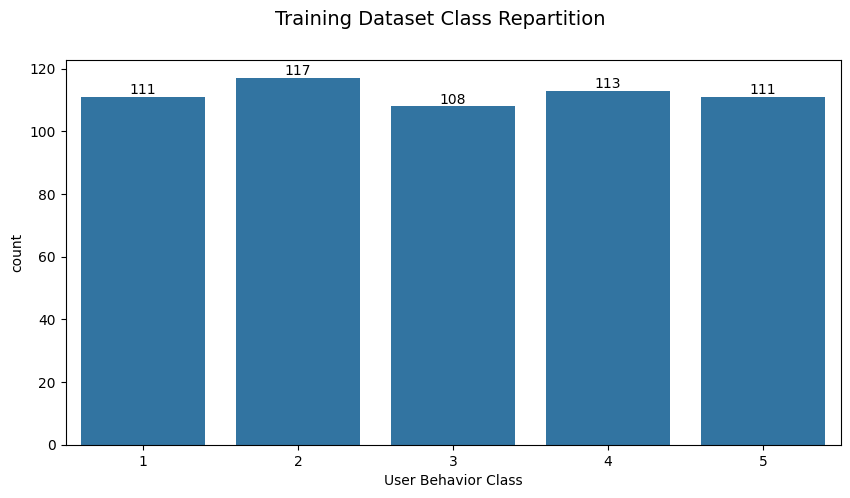

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = sns.countplot(data = df_train, x=target_class_name)
ax.bar_label(ax.containers[0])

fig.add_axes(ax)
fig.suptitle('Training Dataset Class Repartition', fontsize=14)
plt.show()

Class repartition is good enouth, no need to apply a stratified train test split. 

In [ ]:
data_folder_path = Path(ModelSelectionConstants.DATA_FOLDER)
data_folder_path.mkdir(exist_ok=True, parents=True)

df_train.to_csv(data_folder_path / 'train_raw.csv', index=False)
df_test.to_csv(data_folder_path / 'test_raw.csv',  index=False)

In [6]:
columns_to_drop = ['User ID', 'Operating System']

X = df_train.drop(columns=columns_to_drop + [target_class_name])
y = df[[target_class_name]]

We drop 'User ID' and 'Operating System' features because they don't add meaningfull informations, as seen in the analysis notebook. 

In [7]:
categorical_feature_names = ['Device Model', 'Gender']

encoder = OneHotEncoder(drop='first')
encoder.fit(X[categorical_feature_names])

encoded_categorical_df = pd.DataFrame(
    encoder.transform(X[categorical_feature_names]).toarray()
    , columns=encoder.get_feature_names_out()
)

encoded_categorical_df.head()


,Device Model_OnePlus 9,Device Model_Samsung Galaxy S21,Device Model_Xiaomi Mi 11,Device Model_iPhone 12,Gender_Male
0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0


In [8]:
def show_feature_distributions(df: pd.DataFrame, title: str = None): 
    n_cols = 3
    n_rows = 2
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(20, 10))
    for i in range(n_rows):
        for j in range(n_cols): 
            col_name = df.columns[i*n_cols+j]

            sns.histplot(data=df, x=col_name, kde=True, ax = axs[i][j])

    if title is not None: 
        fig.suptitle(title, fontsize=14)
    plt.show()

In [9]:
numeric_col_names = [
    'App Usage Time (min/day)',
    'Screen On Time (hours/day)',
    'Battery Drain (mAh/day)',
    'Number of Apps Installed',
    'Data Usage (MB/day)',
    'Age'
]

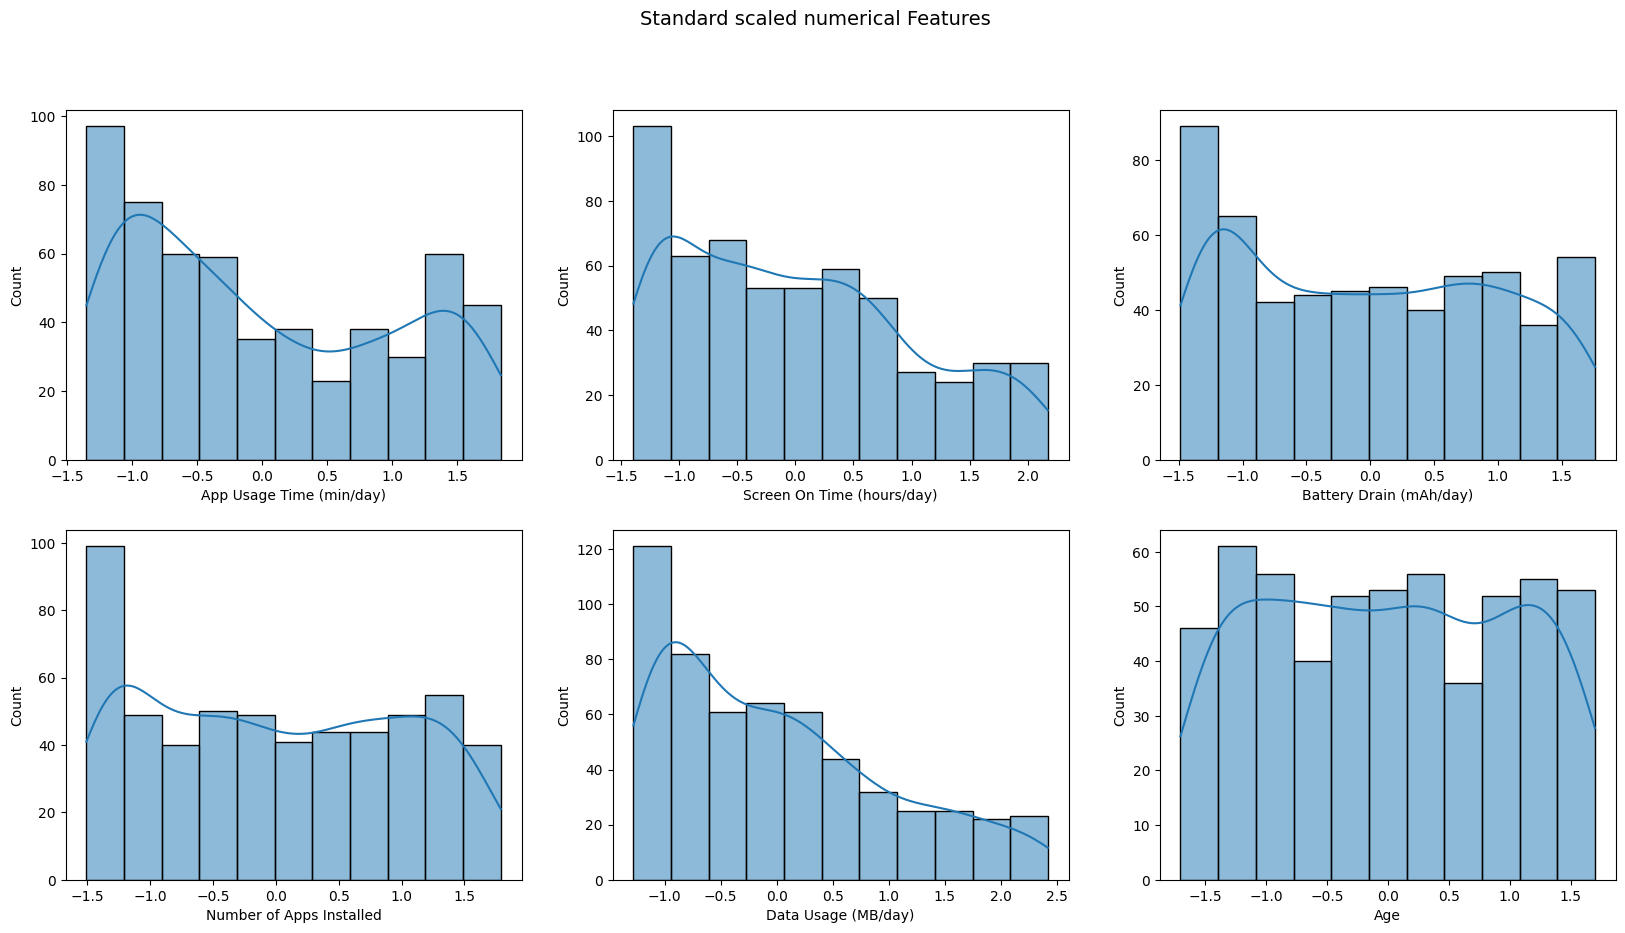

In [10]:
standard_scaler = StandardScaler() 
standard_scaled_X = pd.DataFrame(standard_scaler.fit_transform(X[numeric_col_names]), columns=standard_scaler.get_feature_names_out())

show_feature_distributions(standard_scaled_X, title='Standard scaled numerical Features')

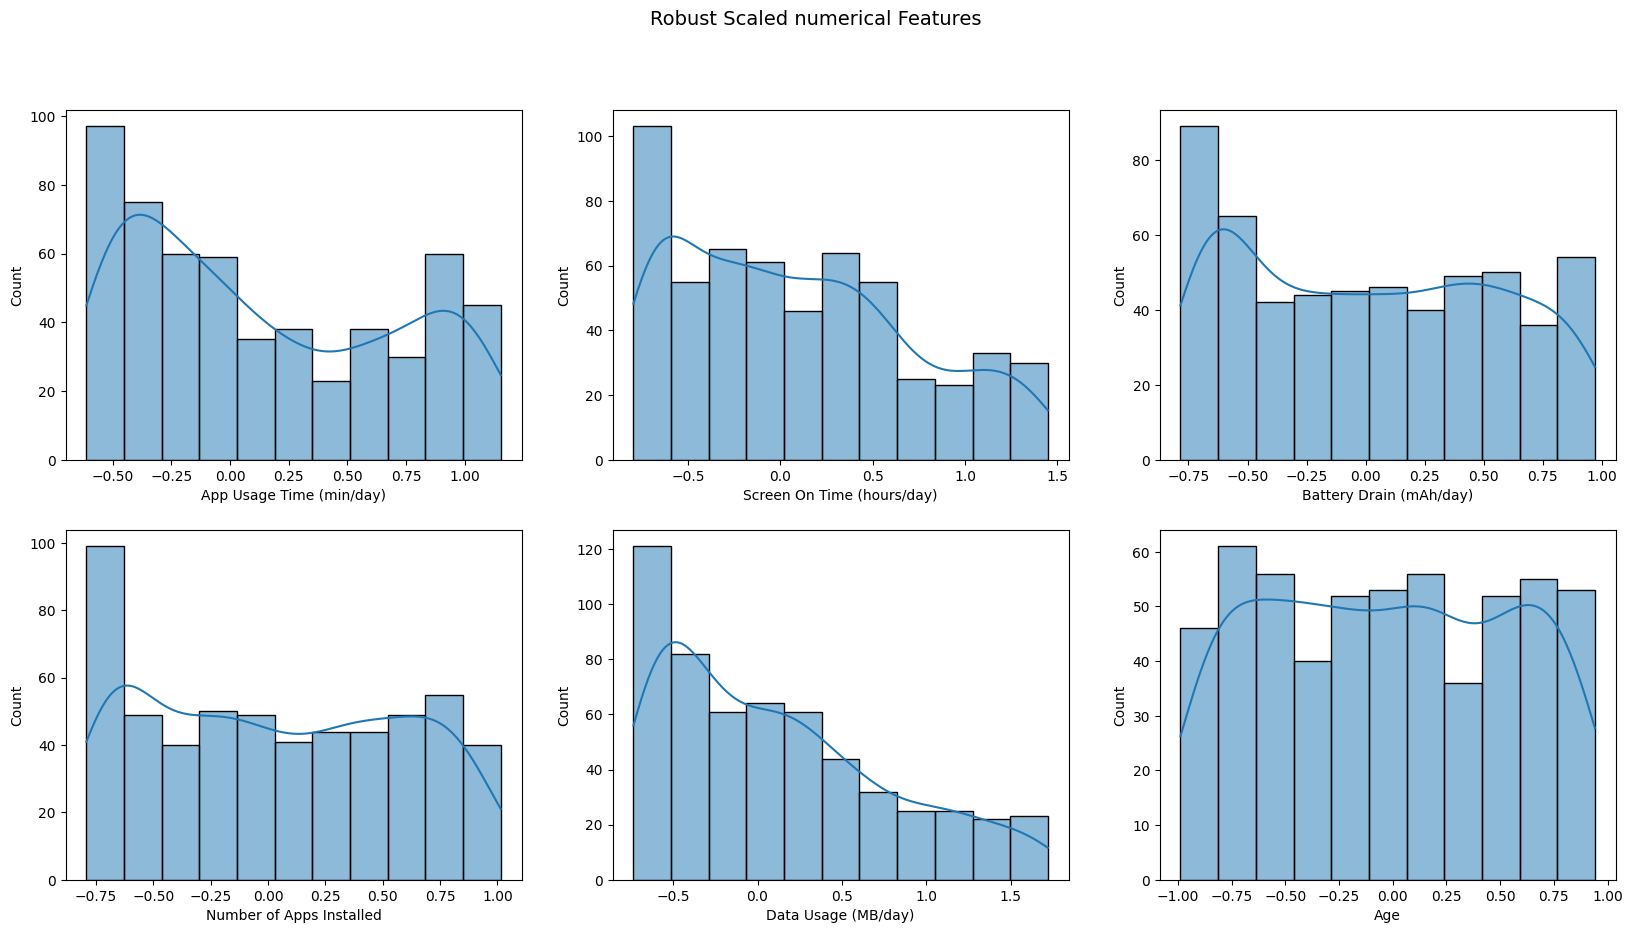

In [ ]:
robust_scaler = RobustScaler()
robust_scaled_X = pd.DataFrame(robust_scaler.fit_transform(X[numeric_col_names]), columns=robust_scaler.get_feature_names_out())

show_feature_distributions(robust_scaled_X, title='Robust Scaled numerical Features')

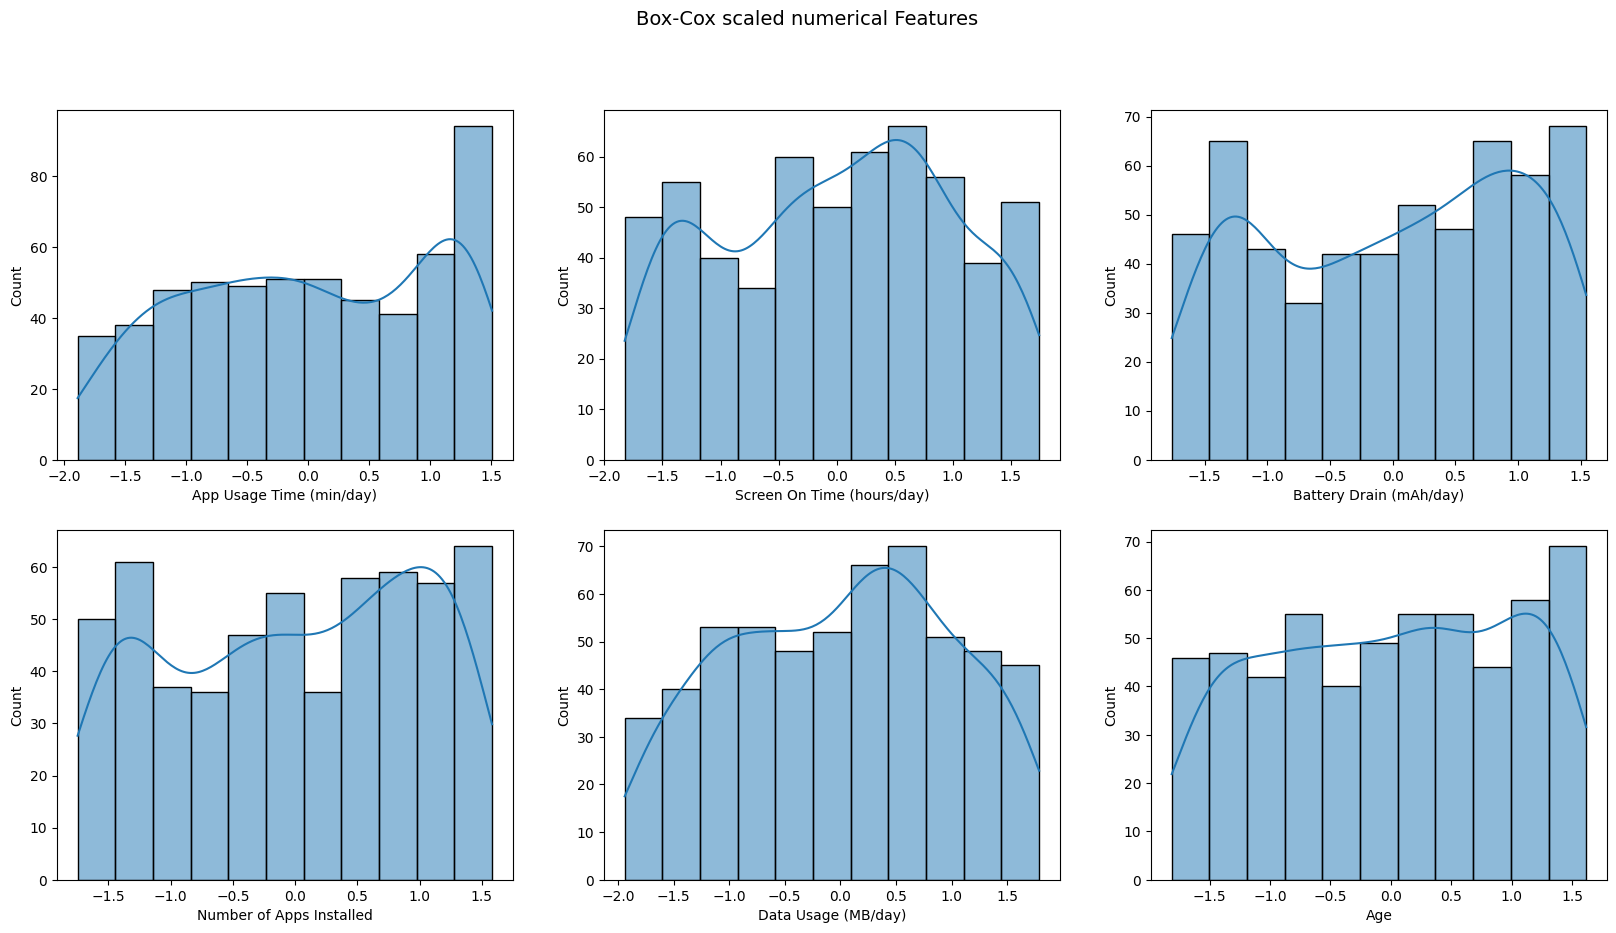

In [11]:
boxcox_scaler = PowerTransformer(method='box-cox')
boxcox_scaled_X = pd.DataFrame(boxcox_scaler.fit_transform(X[numeric_col_names]), columns=boxcox_scaler.get_feature_names_out())

show_feature_distributions(boxcox_scaled_X, title='Box-Cox scaled numerical Features')

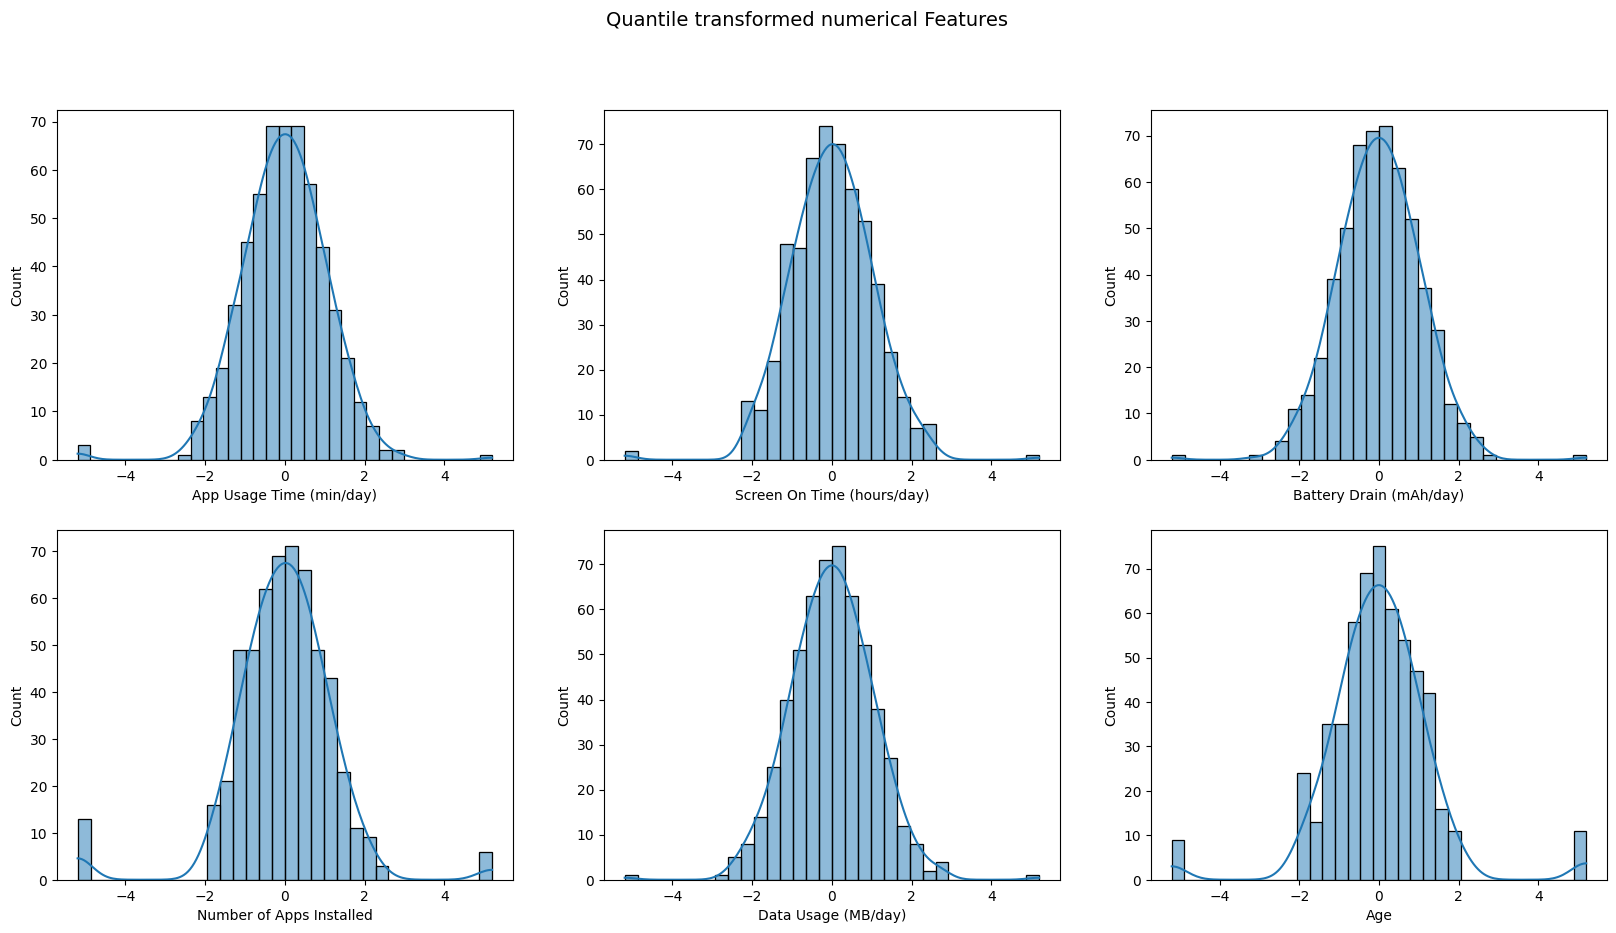

In [23]:
quantile_scaler = QuantileTransformer(output_distribution='normal', random_state=RandomStateConstants.QUANTILE_SCALER, n_quantiles=50)
quantile_scaled_X = pd.DataFrame(quantile_scaler.fit_transform(X[numeric_col_names]), columns=quantile_scaler.get_feature_names_out())

show_feature_distributions(quantile_scaled_X, title='Quantile transformed numerical Features')

Quantile Transformer performs very well on the numeric features, resulting in almost Normal distributions with couple outliers here and there.

In [ ]:
column_tranformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(drop='first'), categorical_feature_names), 
        ('scaler', QuantileTransformer(output_distribution='normal', random_state=RandomStateConstants.QUANTILE_SCALER, n_quantiles=50), numeric_col_names),
        ('target', 'passthrough', [target_class_name])
    ], 
    remainder='drop', 
    n_jobs = -1
)

column_tranformer.fit(df_train)

processed_train_df = pd.DataFrame(column_tranformer.transform(df_train), columns=column_tranformer.get_feature_names_out())
processed_test_df = pd.DataFrame(column_tranformer.transform(df_test), columns=column_tranformer.get_feature_names_out())
processed_train_df.head()

,encoder__Device Model_OnePlus 9,encoder__Device Model_Samsung Galaxy S21,encoder__Device Model_Xiaomi Mi 11,encoder__Device Model_iPhone 12,encoder__Gender_Male,scaler__App Usage Time (min/day),scaler__Screen On Time (hours/day),scaler__Battery Drain (mAh/day),scaler__Number of Apps Installed,scaler__Data Usage (MB/day),scaler__Age,target__User Behavior Class
0,0.0,0.0,0.0,0.0,1.0,-1.920848,-1.162831,-1.168926,-0.981126,-1.227309,0.901454,1.0
1,0.0,1.0,0.0,0.0,1.0,-0.035817,0.180012,-0.165417,-0.154074,-0.077195,0.025581,3.0
2,0.0,0.0,1.0,0.0,0.0,1.326381,1.090600,0.932397,1.782212,1.126788,0.981126,5.0
3,0.0,0.0,0.0,0.0,0.0,-0.932612,-1.067571,-0.964457,-1.162831,-0.925421,-0.596232,1.0
4,1.0,0.0,0.0,0.0,1.0,-5.199338,-1.544575,-1.220421,-1.162831,-1.067571,-0.180012,1.0


In [48]:
processed_train_df.to_csv(data_folder_path / 'train_processed.csv', index=False)
processed_test_df.to_csv(data_folder_path / 'test_processed.csv', index=False)